## Load libraries

In [1]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
import pandas as pd
import ast                      # convert string to list after importing csv data
import pickle

# Libraries to cluster data
from hdbscan import HDBSCAN

# Libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from cluster_visualization_helper import (
    visualize_cluster)  # user-defined functions

# Libraries for evaluation
from sklearn import metrics

# Libraries for monitoring operation process
from datetime import datetime
from tqdm import tqdm
from joblib import Memory

## Configurate and declare global variables

In [2]:
os_name = os.name

if os_name == 'nt':  
    """Windows platform"""
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
elif os_name == 'posix':
    """Linux platform"""
    BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"

SEED = 6886
%matplotlib inline

## Import data

In [3]:
skill_embeddings = np.load(OUTPUT_DIR + "skill_doc_halfsize_embeddings.npy")
skill_embeddings.shape

(94941, 150)

In [6]:
skill_docs = pd.read_csv(
    OUTPUT_DIR + "skill_tokens_long_df.csv",
    converters={
        "skill_token": ast.literal_eval,
    },
    dtype={
        "key_id": int,
        "skill_id": int,
        "job_id": int,
        "column_type": str,
        "skill": str,
        "skill_lemma": str
    }
)
skill_docs.shape

(257450, 7)

In [7]:
skill_docs.iloc[:10, ]

,key_id,job_id,skill_id,column_type,skill,skill_lemma,skill_token
0,101,1,1,job_description,ameria investment consulting company,ameria investment consult company,"[ameria, investment, consult, company]"
1,102,1,2,job_description,provides highly responsible,provide highly responsible,"[provide, highly, responsible]"
2,103,1,3,job_description,complex staff assistance,complex staff assistance,"[complex, staff, assistance]"
3,104,1,4,job_description,chief financial officer,chief financial officer,"[chief, financial, officer]"
4,105,1,5,job_description,investment management,investment management,"[investment, management]"
5,201,2,1,job_description,irex currently seeks,irex currently seek,"[irex, currently, seek]"
6,202,2,2,job_description,position reports directly,position report directly,"[position, report, directly]"
7,203,2,3,job_description,cc program manager,cc program manager,"[cc, program, manager]"
8,204,2,4,job_description,yerevan office,yerevan office,"[yerevan, office]"
9,205,2,5,job_description,community connections,community connection,"[community, connection]"


## Clustering data

### HDBSCAN

In [8]:
def hdbscan_clusterer(X, min_samples, min_cluster_size, memory):
    """Generate clusters using HDBSCAN method
    Hierarchical Density-Based Spatial Clustering of Applications with Noise

    Args:
        X:                 Matrix of features
                             (n_samples, n_features)
        min_samples:       The number of samples in a neighborhood for a point
                             to be considered as a core point
                             (int, default=None)
        min_cluster_size:  The minimum size of clusters
                             (int, default=5)

    Returns:
        Trained clustering model based on X
    """
    clusterer = HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size,
#         algorithm='boruvka_kdtree',
        gen_min_span_tree=True,
        core_dist_n_jobs=8,
        memory=memory,
    )
    clusterer.fit(X)
    return clusterer

In [14]:
# Define search space for tuning hyperparameters
X = skill_embeddings
mem = Memory(location=OUTPUT_DIR + "/cachedir")
model_list = []
duration_list = []
model_result = {
    "min_samples": [],
    "min_cluster_size": [],
    "duration": [],
    "number_clusters": [],
    "Silhouette": [],
    "Davies-Bouldin": [],
    "Calinski Harabasz": [],
}
min_samples_list = [3, 5, 10, 25]
min_cluster_size_list = [3, 5, 10, 25, 50, 100]
len(min_samples_list) * len(min_cluster_size_list)

24

In [ ]:
# Tuning hyperparameter
start_loop_time = datetime.now()
print("Start loop", start_loop_time.strftime("%Y-%m-%d %H:%M:%S.%f"))

tqdm_bar = tqdm(
    desc="Tuning HDBSCAN Clustering",
    total=len(min_samples_list) * len(min_cluster_size_list),
)
for min_samples in min_samples_list:
    for min_cluster_size in min_cluster_size_list:

        starttime = datetime.now()
        print("Start", starttime.strftime("%Y-%m-%d %H:%M:%S.%f"))
        print('min_samples =', min_samples)
        print('min_cluster_size =', min_cluster_size)

        clusterer = hdbscan_clusterer(X, min_samples, min_cluster_size, mem)

        endtime = datetime.now()
        print("End", endtime.strftime("%Y-%m-%d %H:%M:%S.%f"))
        print("Duration", endtime - starttime)

        # Save model
        pickle.dump(
            clusterer,
            open(
                OUTPUT_DIR
                + "hdbscan/"
                + "skills_hdbscan_halfsize_model_min_samples-"
                + str(min_samples)
                + "_min_cluster_size-"
                + str(min_cluster_size)
                + ".pkl",
                "wb",
            ),
        )

        model_list.append(clusterer)
        model_result['duration'].append(round((endtime - starttime).seconds / 60, 4))
        model_result['min_samples'].append(min_samples)
        model_result['min_cluster_size'].append(min_cluster_size)

        tqdm_bar.update(1)

tqdm_bar.close()
end_loop_time = datetime.now()
print("End loop", end_loop_time.strftime("%Y-%m-%d %H:%M:%S.%f"))
print("Duration", end_loop_time - start_loop_time)

Tuning HDBSCAN Clustering:   0%|                                                                | 0/24 [00:00<?, ?it/s]

Start loop 2021-05-15 23:27:13.932197
Start 2021-05-15 23:27:13.939167
min_samples = 3
min_cluster_size = 3
________________________________________________________________________________
[Memory] Calling hdbscan.hdbscan_._hdbscan_prims_kdtree...
_hdbscan_prims_kdtree(array([[-6.771217e-08, ...,  6.251730e-03],
       ...,
       [-1.126416e-07, ..., -8.007766e-02]]), 
3, 1.0, 'euclidean', None, 40, True)


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\hdbscan\hdbscan_.py:217: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  warn('Cannot generate Minimum Spanning Tree; '


_________________________________________hdbscan_prims_kdtree - 2008.3s, 33.5min
End 2021-05-16 00:00:46.851654
Duration 0:33:32.912487


Tuning HDBSCAN Clustering:   4%|██▏                                                | 1/24 [33:33<12:52:01, 2014.00s/it]

Start 2021-05-16 00:00:47.940472
min_samples = 3
min_cluster_size = 5
End 2021-05-16 00:00:50.165182
Duration 0:00:02.224710


Tuning HDBSCAN Clustering:   8%|████▍                                                | 2/24 [33:37<5:04:47, 831.23s/it]

Start 2021-05-16 00:00:51.230709
min_samples = 3
min_cluster_size = 10
End 2021-05-16 00:00:52.722707
Duration 0:00:01.491998


Tuning HDBSCAN Clustering:  12%|██████▋                                              | 3/24 [33:39<2:38:28, 452.79s/it]

Start 2021-05-16 00:00:53.673960
min_samples = 3
min_cluster_size = 25
End 2021-05-16 00:00:54.813226
Duration 0:00:01.139266


Tuning HDBSCAN Clustering:  17%|████████▊                                            | 4/24 [33:41<1:31:37, 274.87s/it]

Start 2021-05-16 00:00:55.793107
min_samples = 3
min_cluster_size = 50
End 2021-05-16 00:00:56.842145
Duration 0:00:01.049038


Tuning HDBSCAN Clustering:  21%|███████████▍                                           | 5/24 [33:43<55:52, 176.44s/it]

Start 2021-05-16 00:00:57.718368
min_samples = 3
min_cluster_size = 100
End 2021-05-16 00:00:58.790367
Duration 0:00:01.071999


Tuning HDBSCAN Clustering:  25%|█████████████▊                                         | 6/24 [33:46<35:12, 117.38s/it]

Start 2021-05-16 00:01:00.437626
min_samples = 5
min_cluster_size = 3
________________________________________________________________________________
[Memory] Calling hdbscan.hdbscan_._hdbscan_prims_kdtree...
_hdbscan_prims_kdtree(array([[-6.771217e-08, ...,  6.251730e-03],
       ...,
       [-1.126416e-07, ..., -8.007766e-02]]), 
5, 1.0, 'euclidean', None, 40, True)


## Evaluate cluster performance

In [ ]:
# Calculate evaluation metrics
label_list = []
model_result['Silhouette'] = []
model_result['Calinski Harabasz'] = []
model_result['Davies-Bouldin'] = []
model_result['number_clusters'] = []

for i in tqdm(range(len(model_list))):
    model = model_list[i]
    cluster_labels = model.labels_
    n = len(np.unique(cluster_labels))

    # Compute Calinski Harabasz Score
    """
    The score is defined as ratio between the within-cluster dispersion and
    the between-cluster dispersion.
    """
    try:
        ch_score = metrics.calinski_harabasz_score(X, cluster_labels)
#         print("Calinski Harabasz Score =", ch_score)
    except Exception as error:
        ch_score = -1.1
        print("n =", n)
        print(
            f"Error in calculating Calinski Harabasz Score: {error}"
        )

    # Compute Davies-Bouldin Score
    """
    The score is defined as the average similarity measure of each cluster with
    its most similar cluster, where similarity is the ratio of within-cluster
    distances to between-cluster distances. Thus, clusters which are farther
    apart and less dispersed will result in a better score.
    The minimum score is zero, with lower values indicating better clustering.
    """
    try:
        db_score = metrics.davies_bouldin_score(X, cluster_labels)
#         print("Davies-Bouldin Score =", db_score)
    except Exception as error:
        db_score = -1.1
        print("n =", n)
        print(f"Error in calculating Davies-Bouldin Score: {error}")

    # Compute Silhouette Score
    """
    The best value is 1 and the worst value is -1. Values near 0 indicate
    overlapping clusters. Negative values generally indicate that a sample has
    been assigned to the wrong cluster, as a different cluster is more similar.
    """
    try:
        silhouette_score = metrics.silhouette_score(
            X, cluster_labels, random_state=SEED, sample_size=10000, n_jobs=-1
        )
#         print("Silhouette Score =", silhouette_score)
    except Exception as error:
        silhouette_score = -1.1
        print("n =", n)
        print(f"Error in calculating Silhouette Score: {error}")

    model_result['Silhouette'].append(silhouette_score)
    model_result['Calinski Harabasz'].append(ch_score)
    model_result['Davies-Bouldin'].append(db_score)
    label_list.append(cluster_labels)
    model_result['number_clusters'].append(n)

In [ ]:
model_result_df = pd.DataFrame(model_result)
model_result_df

In [ ]:
# # Calculate other validation indices
# model_validation = {
#     "min_samples": model_result["min_samples"],
#     "min_cluster_size": model_result["min_cluster_size"],
#     "number_clusters": model_result["number_clusters"],
#     "relative_validity": [],
#     "cluster_persistence": [],
# }

# for i in tqdm(range(len(model_list))):
#     model = model_list[i]

#     # Retrieve relative validity
#     """
#     float
#     A fast approximation of the Density Based Cluster Validity (DBCV) score. 
#     The only difference, and the speed, comes from the fact that 
#     this relative_validity_ is computed using 
#     the mutual- reachability minimum spanning tree, i.e. minimum_spanning_tree_, 
#     instead of the all-points minimum spanning tree used in the reference. 
#     This score might not be an objective measure of 
#     the goodness of clusterering. 
#     It may only be used to compare results across 
#     different choices of hyper-parameters, therefore is only a relative score.
#     """
#     relative_validity = model.relative_validity_

#     # Retrieve cluster persistence
#     """
#     ndarray, shape (n_clusters, )
#     A score of how persistent each cluster is. 
#     A score of 1.0 represents a perfectly stable cluster 
#     that persists over all distance scales, 
#     while a score of 0.0 represents a perfectly ephemeral cluster. 
#     These scores can be gauge the relative coherence 
#     of the clusters output by the algorithm.
#     """
#     cluster_persistence = model.cluster_persistence_

#     model_validation["relative_validity"].append(relative_validity)
#     model_validation["cluster_persistence"].append(cluster_persistence)

In [ ]:
# Combine model sets
tuple_objects = (
    min_samples_list,
    min_cluster_size_list,
    model_list,
    duration_list,
    label_list,
    model_result,
#     model_validation
)
len(tuple_objects), len(tuple_objects[0])

In [ ]:
# Save tuple
pickle.dump(tuple_objects, open(OUTPUT_DIR + "hdbscan/" + "skills_hdbscan_halfsize_model_list.pkl", "wb"))

In [ ]:
# # Load pickle
# (
#     min_samples_list,
#     min_cluster_size_list,
#     model_list,
#     duration_list,
#     label_list,
#     model_result,
#     model_validation
# ) = pickle.load(open(OUTPUT_DIR + "skills_hdbscan_halfsize_model_list.pkl", "rb"))

#### Number of clusters found

In [ ]:
palette = sns.color_palette("hls", n_colors=len(min_cluster_size_list))

# The higher the better
plt.figure(figsize=(12, 6))
for idx, min_samples in enumerate(min_samples_list):
    plt.plot(
        model_result_df["min_cluster_size"].loc[
            model_result_df["min_samples"] == min_samples
        ],
        model_result_df["number_clusters"].loc[
            model_result_df["min_samples"] == min_samples
        ],
        label="Min samples = "
        + str(min_samples),
        color=palette[idx]
    )
plt.ylabel("Number of clusters")
# plt.yticks(np.unique(model_result_df["number_clusters"]))
plt.xlabel("Min cluster size")
# plt.xticks(np.unique(model_result_df["min_samples"]))
plt.title("Number of clusters for HDBSCAN clustering")
plt.legend(loc="best")
plt.grid()
plt.show()

#### Silhoulette score

In [ ]:
palette = sns.color_palette("hls", n_colors=len(min_samples_list))

# The higher the better
fig, ax1 = plt.subplots(figsize=(12, 6))
for idx, min_samples in enumerate(min_samples_list):
    ax1.plot(
        model_result_df["min_cluster_size"].loc[
            model_result_df["min_samples"] == min_samples
        ],
        model_result_df["Silhouette"].loc[
            model_result_df["min_samples"] == min_samples
        ],
        label="Min samples = "
        + str(min_samples), color=palette[idx]
    )
ax1.set_xlabel("Min Cluster Size")
# ax1.set_xticks(min_cluster_size_list)
ax1.set_ylabel("Silhouette Score")
ax1.set_title("Silhouette score for HDBSCAN clustering")
ax1.legend(loc="best")
ax1.grid()
plt.show()

#### Calinski Harabasz Score

In [ ]:
palette = sns.color_palette("hls", n_colors=len(min_samples_list))

# The higher the better
fig, ax1 = plt.subplots(figsize=(12, 6))
for idx, min_samples in enumerate(min_samples_list):
    ax1.plot(
        model_result_df["min_cluster_size"].loc[
            model_result_df["min_samples"] == min_samples
        ],
        model_result_df["Calinski Harabasz"].loc[
            model_result_df["min_samples"] == min_samples
        ],
        label="Min samples = "
        + str(min_samples), color=palette[idx]
    )
ax1.set_xlabel("Min Cluster Size")
# ax1.set_xticks(min_cluster_size_list)
ax1.set_ylabel("Calinski Harabasz Score")
ax1.set_title("Calinski Harabasz score for HDBSCAN clustering")
ax1.legend(loc="best")
ax1.grid()
plt.show()

#### Davies-Bouldin Score

In [ ]:
palette = sns.color_palette("hls", n_colors=len(min_samples_list))

# Closer to 0 is better
fig, ax1 = plt.subplots(figsize=(12, 6))
for idx, min_samples in enumerate(min_samples_list):
    ax1.plot(
        model_result_df["min_cluster_size"].loc[
            model_result_df["min_samples"] == min_samples
        ],
        model_result_df["Davies-Bouldin"].loc[
            model_result_df["min_samples"] == min_samples
        ],
        label="Min samples = "
        + str(min_samples), color=palette[idx]
    )
ax1.set_xlabel("Min Cluster Size")
# ax1.set_xticks(min_cluster_size_list)
ax1.set_ylabel("Davies-Bouldin Score")
ax1.set_title("Davies-Bouldin score for HDBSCAN clustering")
ax1.legend(loc="best")
ax1.grid()
plt.show()

#### Relative validity

In [ ]:
# model_validation_df = pd.DataFrame(
#     {
#         "min_samples": model_validation["min_samples"],
#         "min_cluster_size": model_validation["min_cluster_size"],
#         "relative_validity": model_validation["relative_validity"],
#     }
# )
# palette = sns.color_palette("hls", n_colors=len(min_samples_list))

# # The higher the better
# plt.figure(figsize=(12, 6))
# for idx, min_samples in enumerate(min_samples_list):
#     plt.plot(
#         model_validation_df["min_cluster_size"].loc[
#             model_validation_df["min_samples"] == min_samples
#         ],
#         model_validation_df["relative_validity"].loc[
#             model_validation_df["min_samples"] == min_samples
#         ],
#         label="Min samples = " + str(min_samples),
#         color=palette[idx],
#     )
# plt.ylabel("Relative validity")
# plt.xlabel("Min cluster size")
# plt.title("Relative validity for HDBSCAN clustering")
# plt.legend(loc="best")
# plt.grid()
# plt.show()

In [ ]:
best_index = np.argmax(model_result_df['Silhouette'])
print(best_index)

best_min_samples = model_result_df['min_samples'][best_index]
best_min_cluster_size = model_result_df['min_cluster_size'][best_index]
print(best_min_samples, best_min_cluster_size)
best_labels = label_list[best_index]
best_n = len(np.unique(best_labels))
best_number_noise = np.sum(np.array(best_labels) == -1, axis=0)
print(best_n, best_number_noise)

## Save cluster results to file

In [27]:
# # Create text and token columns
# skill_docs["feature_skills_tokens"] = (
#     skill_docs["skill_description_tokens"] + skill_docs["skill_requirement_tokens"]
# )

# skill_docs["feature_skills"] = (
#     skill_docs["job_description"] + skill_docs["job_requirement"]
# )

In [ ]:
df_clusters = skill_docs
df_clusters["model_type"] = "hdbscan"
df_clusters["number_clusters"] = best_n
df_clusters["skill_cluster"] = best_labels

In [ ]:
df_clusters

In [ ]:
df_clusters.to_csv(
    OUTPUT_DIR + "hdbscan/" + "job-skill-clusters_hdbscan_halfsize.csv", index=False
)

## Visualize clusters

In [34]:
pca_datapoint = np.load(OUTPUT_DIR + "visualization/" + "skills_wide_pca_datapoints.npy")
tsne_datapoint = np.load(OUTPUT_DIR + "visualization/" + "skills_wide_tsne_datapoints.npy")

Start PCA 2021-05-07 00:33:22.348141
End PCA 2021-05-07 00:33:22.406193
PCA duration 0:00:00.058052

Start t-SNE 2021-05-07 00:33:22.409143
End t-SNE 2021-05-07 00:33:22.462190
t-SNE duration 0:00:00.053047



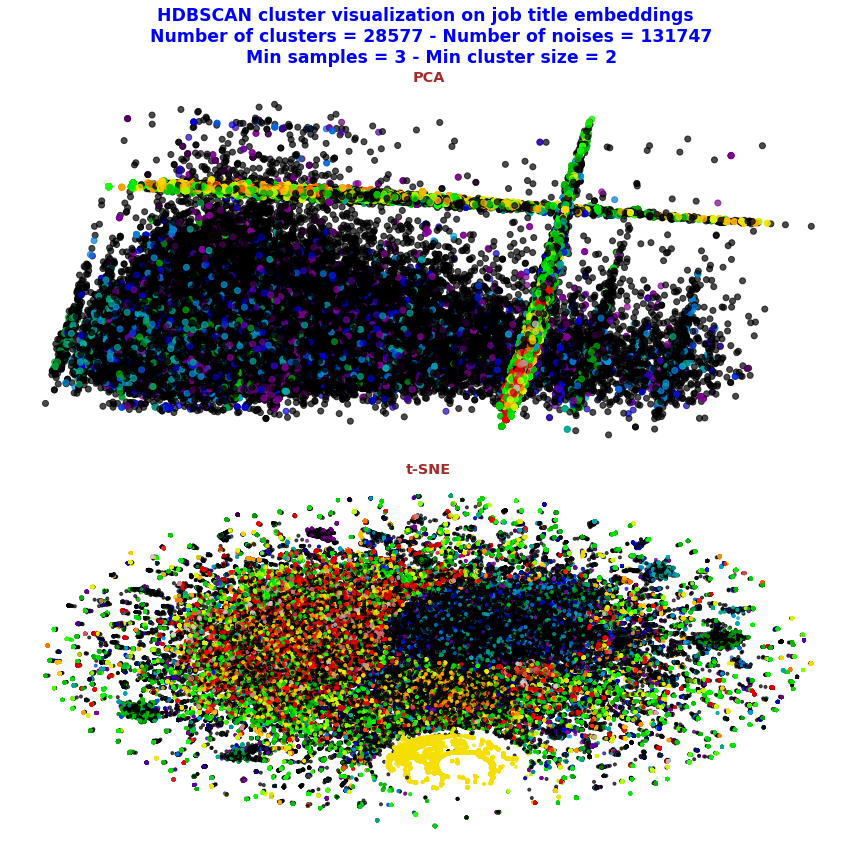

In [35]:
plot_title = (
    "HDBSCAN cluster visualization on job skill embeddings \n Number of clusters = "
    + str(best_n) + " - Number of noises = " + str(best_number_noise)
    + "\n Min samples = "
    + str(best_min_samples)
    + " - Min cluster size = "
    + str(best_min_cluster_size)
)
palette = sns.color_palette("hls", as_cmap=True)
colors = cm.nipy_spectral(best_labels.astype(float) / best_n)

# Visualize clusters with PCA and t-SNE
visualize_cluster(
    plot_title,
    (12, 12),
    colors,
    palette,
    pca_datapoint,
    tsne_datapoint,
    None,
    pca=True,
    tsne=True,
    mds=False,
)